# Plotting with scalar data

We are about to build a compound mesh by transforming parts of a voxlized cylinder into tetrahedra and lines. Then we do some plotting and review the basics of configuring plots.

In [1]:
from sigmaepsilon.mesh.space import CartesianFrame
from sigmaepsilon.mesh.recipes import cylinder
from sigmaepsilon.mesh import PolyData, LineData, PointData
from sigmaepsilon.mesh.cells import H8, Q4, L2
from sigmaepsilon.mesh.utils.topology import H8_to_L2, H8_to_Q4
from sigmaepsilon.mesh.utils.topology import detach_mesh_bulk
from sigmaepsilon.mesh.utils.space import frames_of_lines, frames_of_surfaces
from sigmaepsilon.math import minmax
import numpy as np

min_radius = 5
max_radius = 25
h = 50
angle = 1

shape = (min_radius, max_radius), angle, h
frame = CartesianFrame(dim=3)
cyl = cylinder(shape, size=5.0, voxelize=True, frame=frame)

coords = cyl.coords()
topo = cyl.topology()
centers = cyl.centers()

cxmin, cxmax = minmax(centers[:, 0])
czmin, czmax = minmax(centers[:, 2])
cxavg = (cxmin + cxmax) / 2
czavg = (czmin + czmax) / 2
b_upper = centers[:, 2] > czavg
b_lower = centers[:, 2] <= czavg
b_left = centers[:, 0] < cxavg
b_right = centers[:, 0] >= cxavg
iL2 = np.where(b_upper & b_right)[0]
iTET4 = np.where(b_upper & b_left)[0]
iH8 = np.where(b_lower)[0]
_, tL2 = H8_to_L2(coords, topo[iL2])
_, tQ4 = H8_to_Q4(coords, topo[iTET4])
tH8 = topo[iH8]

pd = PointData(coords=coords, frame=frame)
mesh = PolyData(pd, frame=frame)

cdL2 = L2(topo=tL2, frames=frames_of_lines(coords, tL2))
mesh["lines", "L2"] = LineData(cdL2, frame=frame)

cdQ4 = Q4(topo=tQ4, frames=frames_of_surfaces(coords, tQ4))
mesh["surfaces", "Q4"] = PolyData(cdQ4, frame=frame)

cH8, tH8 = detach_mesh_bulk(coords, tH8)
pdH8 = PointData(coords=cH8, frame=frame)
cdH8 = H8(topo=tH8, frames=frame)
mesh["bodies", "H8"] = PolyData(pdH8, cdH8, frame=frame)

mesh.to_standard_form()
mesh.lock(create_mappers=True)

PolyData({'lines': PolyData({'L2': PolyData({})}), 'surfaces': PolyData({'Q4': PolyData({})}), 'bodies': PolyData({'H8': PolyData({})})})

We can assign colors by setting numerical data on points or cells. All we have to do
is to provide the keyword argument ``scalars`` to `PyVista`. One way to do that is to
add these walues to the configuration of your block of choice. For example, to set random data on H8 hexagonals, do this:

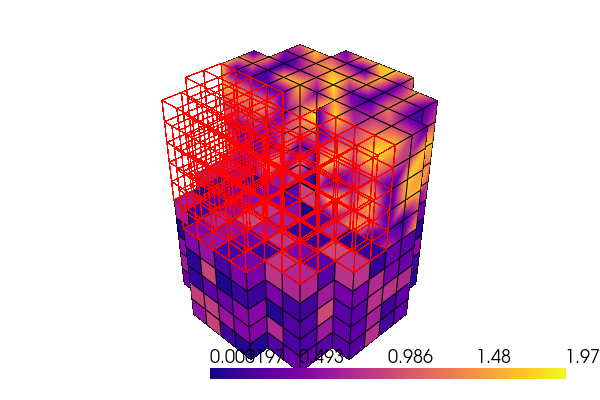

In [2]:
mesh["lines", "L2"].config["pyvista", "plot", "color"] = "red"
mesh["lines", "L2"].config["pyvista", "plot", "line_width"] = 1.5
mesh["lines", "L2"].config["pyvista", "plot", "render_lines_as_tubes"] = True

mesh["bodies", "H8"].config["pyvista", "plot", "scalars"] = np.random.rand(tH8.shape[0])
ncTET4 = mesh["surfaces", "Q4"].coords(from_cells=True).shape[0]

mesh["surfaces", "Q4"].config["pyvista", "plot", "scalars"] = 2 * np.random.rand(ncTET4)
mesh["surfaces", "Q4"].config["pyvista", "plot", "opacity"] = 1.0

mesh.pvplot(
    notebook=True,
    jupyter_backend="static",
    window_size=(600, 400),
    config_key=["pyvista", "plot"],
    cmap="plasma",
    theme="document",
)

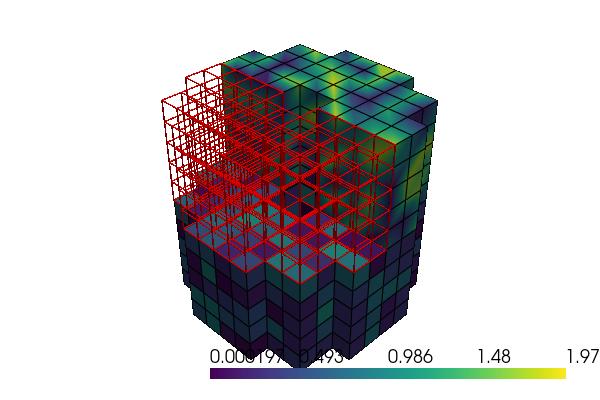

In [3]:
import pyvista as pv

plotter = pv.Plotter(theme=pv.themes.DocumentTheme())
plotter = mesh.pvplot(
    plotter=plotter,
    config_key=["pyvista", "plot"],
    return_plotter=True,
)
plotter.show(jupyter_backend="static", window_size=(600, 400))